In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%pwd

'/home/bene/projects/generative-models/examples'

In [3]:
juypter_root = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
%cd $juypter_root

/home/bene/projects/generative-models


In [4]:
BATCH_SIZE = 128
LEARNING_RATE = 0.01

EMB_LOSS = 1.

EPOCHS = 10

In [5]:
from gempy.let_it_scan_images import Lisi

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

In [6]:
def get_MNIST(batch_size, dataset_directory, dataloader_workers, source='MNIST'):
    # Prepare dataset for training
    train_transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    
    data_source = getattr(torchvision.datasets, source)
    
    train_dataset = data_source(root=dataset_directory, train=True, download=True, transform=train_transformation)

    test_dataset =  data_source(root=dataset_directory, train=False, download=True, transform=train_transformation)

    # Prepare Data Loaders for training and validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               pin_memory=True, num_workers=dataloader_workers)

    # Prepare Data Loaders for training and validation
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                              pin_memory=True, num_workers=dataloader_workers)

    return train_dataset, test_dataset, train_loader, test_loader

In [7]:
train_dataset, test_dataset, train_loader, test_loader = get_MNIST(BATCH_SIZE, 'examples/dataset', 12, 'MNIST')

input shape: (1, 28, 28)


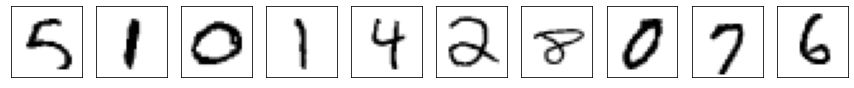

In [8]:
f, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax in axes:
    tensor = train_dataset[np.random.randint(len(train_dataset))][0]
    ax.imshow(tensor.detach().numpy().transpose(1,2,0), cmap='binary')
    ax.set_xticks([]); ax.set_yticks([])

input_shape = tuple(train_dataset[0][0].shape)
print('input shape:', input_shape)

In [9]:
IN_CHANNELS = input_shape[0]
KERNEL_SIZE = 3
EMBEDDING_SIZE = 32
DOPOUT = 0.5
HIDDEN_SIZE = 10
N_COMPONENTS = 5

OUTPUT_SIZE = 10

NOISE_LEVEL = 0.025
MAX_ITER = 0.75

In [10]:
head = nn.Sequential(nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE), 
                     nn.ELU(),  # nn.LeakyReLU(),
                    )

In [11]:
device = 'cpu'
if torch.cuda.is_available():
    print (f'GPU available')
    device = 'cuda'

GPU available


In [12]:
model = Lisi(in_channels=IN_CHANNELS, 
             kernel_size=KERNEL_SIZE,
             embedding_size=EMBEDDING_SIZE,
             dropout=DOPOUT,
             hidden_size=HIDDEN_SIZE,
             n_components=N_COMPONENTS,
             head=head,
             noise_level=NOISE_LEVEL,
             max_iter=MAX_ITER,
            )

model = model.to(device)

In [13]:
x_random = torch.randn(2, *input_shape, device=device)
y, *args = model(x_random)
y.shape, y

(torch.Size([2, 10]),
 tensor([[ 0.6198,  0.1085,  0.2727, -0.1241, -0.0731,  0.2415, -0.3962, -0.1846,
          -0.0969, -0.3116],
         [ 0.5968,  0.1218,  0.3260, -0.0768, -0.0927,  0.2820, -0.4077, -0.0850,
          -0.0596, -0.2974]], device='cuda:0', grad_fn=<EluBackward0>))

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion_cat = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()

In [ ]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, (coords, target_embeddings, predicted_embeddings) = model(inputs)
        loss_mnist = criterion_cat(outputs, labels)
        loss_embedding = criterion_mse(predicted_embeddings, target_embeddings[:, 1:])
        loss = loss_mnist + loss_embedding * EMB_LOSS
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 3.729
[1,    40] loss: 3.428


##### 